In [1]:
from IPython.display import Video

import os.path as osp
import pickle
import PIL

from homan.datasets.ho3d import HO3D

/home/deepthought/.miniconda3/envs/phosa16_env/lib/python3.7/site-packages/libyana/meshutils/meshio.py:9: UserWarning: Could not laod tinyobjloader for faster_load_obj, use fast_load_obj
  "Could not laod tinyobjloader for faster_load_obj, use fast_load_obj"
/home/deepthought/.miniconda3/envs/phosa16_env/lib/python3.7/site-packages/manopth/manolayer.py:72: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1595629403081/work/torch/csrc/utils/tensor_numpy.cpp:141.)
  torch.Tensor(smpl_data['betas'].r).unsqueeze(0))


In [4]:
dataset = HO3D(split='val', mode='vid', frame_nb=-1, track=True)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:09<00:00,  1.16it/s]


Chunking 11 videos in chunks of size -1, skipping 4, every -4 frames


# Visualize Track

In [8]:
with open('data/boxes/boxes_ho3d_val.pkl', 'rb') as fp:
    boxes = pickle.load(fp)

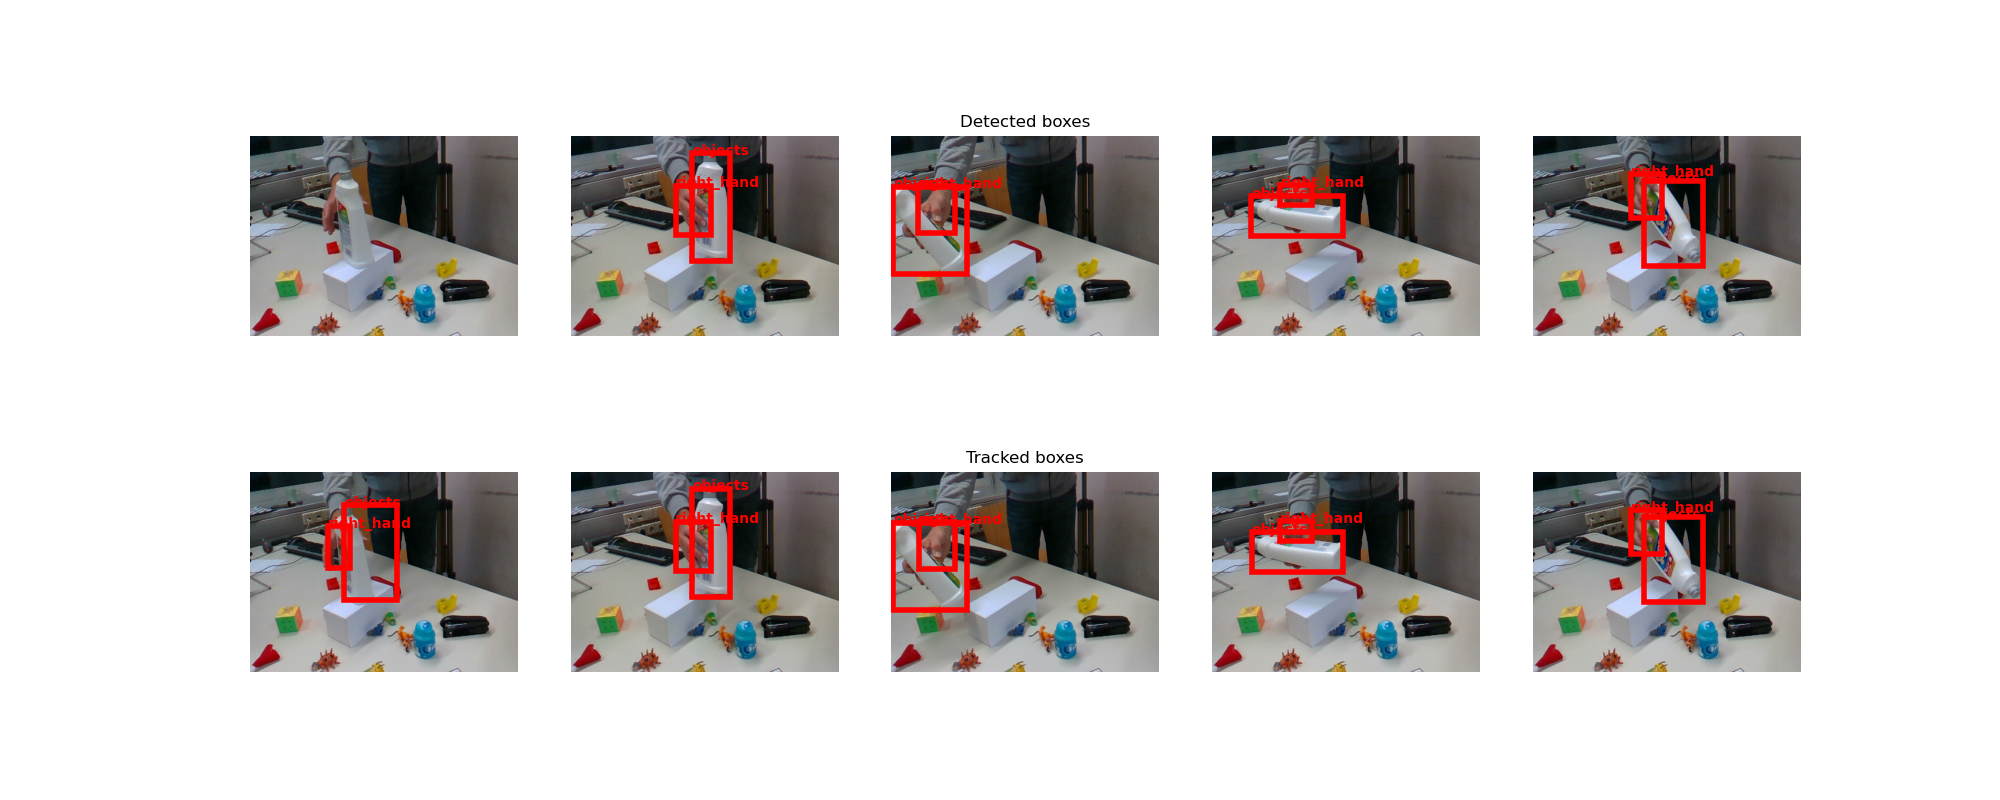

In [ ]:
PIL.Image.open('tracks/tmptrack0.png')

In [10]:
with open('results/ho3d/step1/results.pkl', 'rb') as fp:
    res = pickle.load(fp)

# Visualize GT using yana's code: Failing

In [19]:
def load_obj(fname):
    """
    Args:
        fname: e.g. '037_scissor/textured_simple.obj'
    Returns: ndarray (n, 3)
    """
    with open(fname, 'r') as fp:
        lines = fp.readlines()
        # char = None
        # while char != 'v':
        #     char = fp.readline().split(' ')[0]
        lines = [l for l in lines if l.split(' ')[0] == 'v']
        # v x y z r g b
        lines = np.float32([
            list(map(float, l.split(' ')[1:4])) for l in lines
        ])
    return lines

In [2]:
import numpy as np
import torch
import pickle
from homan import getdataset
from homan.visualize import visualize_hand_object
from homan.homan import HOMan
from homan.meshutils import get_faces_and_textures
import neural_renderer as nr
import matplotlib.pyplot as plt

In [3]:
dataset, image_size = getdataset.get_dataset(
    'ho3d',
    split='test',
    frame_nb = 10,
    box_mode='gt',
    chunk_step=4)

/home/deepthought/Zhifan/homan/homan/datasets/ho3d.py:116: UserWarning: Using seqs {'MPM13', 'SB13', 'MPM12', 'SB11', 'AP14', 'MPM14', 'AP12', 'MPM11', 'AP10', 'AP11', 'AP13', 'MPM10', 'SM1'} for evaluation
  warnings.warn(f"Using seqs {seqs} for evaluation")


Using seqs {'MPM13', 'SB13', 'MPM12', 'SB11', 'AP14', 'MPM14', 'AP12', 'MPM11', 'AP10', 'AP11', 'AP13', 'MPM10', 'SM1'} for evaluation
Chunking 13 videos in chunks of size 10, skipping 4, every 40 frames


[ 0.01778413 -0.03398376  0.48374534]


/home/deepthought/Zhifan/homan/homan/datasets/ho3d.py:448: UserWarning: Problem with gt bboxes ?
  warnings.warn(f"Problem with gt bboxes ?")


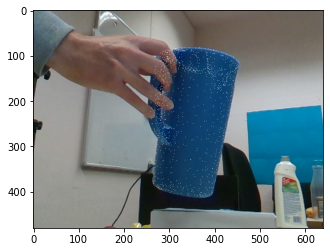

In [4]:
vid_info = dataset.vid_index.iloc[0]
rgb, camera, hand_info, obj_info = dataset.get_frame_info(vid_info, 0)

#  I can viz
pts = obj_info['verts3d']
print(pts.mean(0))
pts = pts / pts[:, -1][:, None]
pts = pts.dot(camera['K'].T) # K
pts = pts.astype(np.int32)
rgb_np = np.asarray(rgb)
rgb_np[pts[:,1], pts[:,0], :] = 255
plt.imshow(rgb_np)

In [5]:
annots = dataset[0]
right_hands = [
    hand for hand in annots["hands"] if hand["label"] == 'right_hand' ]
left_hands = [
    hand for hand in annots["hands"] if hand["label"] == 'left_hand' ]
setup = annots['setup']

gt_hand_verts = []
gt_hand_verts = torch.from_numpy( np.concatenate( [annot['verts3d'] for annot in annots['hands']], 1).astype(np.float32) )
# gt_object_verts = torch.from_numpy( np.concatenate( [annot['verts3d'] for annot in annots['objects']], 1) )

camintr = annots['camera']['K'].copy()
camintr = torch.from_numpy(camintr)
rot = torch.cuda.FloatTensor([[1,0,0],[0,1,0],[0,0,1]])
renderer = nr.renderer.Renderer(image_size=image_size,
                                K=camintr.clone(),
                                R=rot,
                                t=torch.zeros(1,3).cuda(),
                                orig_size=1)

max_in_batch = 2
viz_len = 10

obj_verts = torch.from_numpy( annots['objects'][0]['verts3d'] )
obj_faces = torch.from_numpy( annots['objects'][0]['faces'] )
with open('extra_data/hand_module/SMPLX_HAND_INFO.pkl', 'rb') as fp:
    hand_info = pickle.load(fp)
right_hand_faces_local = torch.from_numpy(  hand_info['right_hand_faces_local'] )

ref_verts_list = [obj_verts[:1]] + [gt_hand_verts[:1]]
ref_faces_list = [obj_faces[:1]] + [right_hand_faces_local[:1]]

faces, textures = get_faces_and_textures(
    ref_verts_list, ref_faces_list, color_names=['gold', 'grey'])

V = torch.cat(ref_verts_list, 1)

# V = ref_verts_list
K = camintr[:1] / 256
print(K)
rot = rot.unsqueeze_(0)
tx = torch.zeros([1,1,3]).cuda()

tensor([[[2.4009, 0.0000, 1.2510],
         [0.0000, 2.3988, 0.9315],
         [0.0000, 0.0000, 0.0039]]])


In [6]:
image, depth, mask = renderer.render(
    vertices=V.cuda(),
    faces=faces.cuda(),
    textures=textures.cuda(),
    K=K.cuda() / 2.0,
    R=rot.cuda(),
    t=tx.cuda())

img_np = image[0].permute(1, 2, 0).cpu().numpy()
mask = mask.cpu().numpy()[0]
rgb_np[mask==1, :]
# depth_np = depth[0].cpu().numpy()

plt.imshow(mask)

IndexError: boolean index did not match indexed array along dimension 0; dimension is 480 but corresponding boolean dimension is 640

# Results

In [ ]:
from IPython.display import Video

In [ ]:
Video("results/ho3d/step1/samples/MPM10_00000100/final_points.mp4")

# HO3D vis

In [7]:
import os, pickle
import os.path as osp
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import torch
import libyana, manopth

In [17]:
ho3d = '/media/deepthought/DATA/Zhifan/HO3D_v2'
abf10 = osp.join(ho3d, 'train/ABF10')
frid = 440
meta = osp.join(abf10, f'meta/{frid:04d}.pkl')
depth = osp.join(abf10, f'depth/{frid:04d}.png')
rgb = osp.join(abf10, f'rgb/{frid:04d}.png')

depth = Image.open(depth)
with open(meta, 'rb') as fp:
    meta = pickle.load(fp)
rgb = Image.open(rgb)

## Naive

In [9]:
def load_obj(fname):
    """
    Args:
        fname: e.g. '037_scissor/textured_simple.obj'
    Returns: ndarray (n, 3)
    """
    with open(fname, 'r') as fp:
        lines = fp.readlines()
        # char = None
        # while char != 'v':
        #     char = fp.readline().split(' ')[0]
        lines = [l for l in lines if l.split(' ')[0] == 'v']
        # v x y z r g b
        lines = np.float32([
            list(map(float, l.split(' ')[1:4])) for l in lines
        ])
    return lines

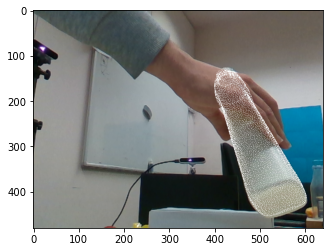

In [18]:
obj = '/media/eve/DATA/Zhifan/YCB_Video_Models/models/021_bleach_cleanser/textured_simple.obj'
obj = load_obj(obj)

K = meta['camMat']
Rot, Trans = meta['objRot'], meta['objTrans']

obj = obj.dot(cv2.Rodrigues(Rot)[0].T) + Trans
pts_c = obj.dot(K.T)
pts_c = pts_c / pts_c[:, -1][:, None]

loc = pts_c.astype(int)
img = np.asarray(rgb).copy()
img[loc[:, 1], 640 - loc[:, 0], : ] = 255
plt.imshow(img); plt.show()

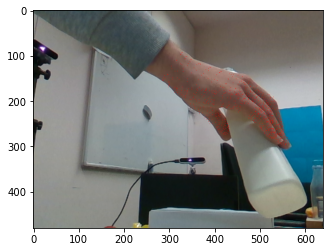

In [19]:
from manopth.manolayer import ManoLayer

layer = ManoLayer(
    mano_root='extra_data/mano/', 
    use_pca=False, 
    ncomps=6,
)

pose = torch.from_numpy(meta['handPose']).unsqueeze_(0)
betas = torch.from_numpy(meta['handBeta']).unsqueeze_(0)
trans = torch.from_numpy(meta['handTrans']).unsqueeze_(0)
verts, Jtr, _ = layer(pose, th_betas=betas, th_trans=trans)

verts = verts[0] / 1000  # From millemetres to meters
verts = verts.cpu().numpy()
verts = verts.dot(K.T)
verts = (verts / verts[:, -1][:, None]).astype(int)

img = np.asarray(rgb).copy()
img[verts[:, 1], 640 - verts[:, 0], : ] = (255, 0, 0)
plt.imshow(img); plt.show()

## pytorch3d

In [20]:
import pytorch3d
from pytorch3d.io import load_objs_as_meshes
from pytorch3d.structures import Meshes
from pytorch3d.structures.meshes import join_meshes_as_scene
from pytorch3d.renderer.mesh import TexturesUV, TexturesVertex
from pytorch3d.renderer import (
    look_at_view_transform,
    RasterizationSettings,
    PointLights,
    MeshRenderer, MeshRasterizer,
    SoftPhongShader,
    PerspectiveCameras, FoVPerspectiveCameras,
)
from pytorch3d.utils import camera_conversions

from homan.meshutils import get_faces_and_textures
from manopth.manolayer import ManoLayer

import cv2
from pytorch3d.transforms.transform3d import Transform3d

def pplt(img_th):
    print(img_th.shape)
    img_np = img_th.detach().cpu().squeeze().numpy()
    plt.imshow(img_np)

obj_raw = '/media/eve/DATA/Zhifan/YCB_Video_Models/models/021_bleach_cleanser/textured_simple.obj'
obj_raw = load_objs_as_meshes([obj_raw])

In [23]:
# Object
R = cv2.Rodrigues(meta['objRot'])[0]
R = torch.from_numpy(R.T)
T = meta['objTrans']
t_rot = Transform3d().rotate(R).scale(1, 1, -1)
t_trans = Transform3d().translate(T[0], T[1], T[2])
t_flip = Transform3d().scale(1, 1, -1)
# t = Transform3d().rotate(R).scale(1, 1, -1).translate(T[0], T[1], T[2])
# t = Transform3d().rotate(R).translate(T[0], T[1], T[2])
obj = obj_raw.update_padded(
    t_trans.transform_points(
        t_rot.transform_points(
            obj_raw.verts_padded()
        )
    )
)

# Hand
layer = ManoLayer(
    mano_root='extra_data/mano/', 
    use_pca=False, 
    ncomps=6)

pose = torch.from_numpy(meta['handPose']).unsqueeze_(0)
betas = torch.from_numpy(meta['handBeta']).unsqueeze_(0)
trans = torch.from_numpy(meta['handTrans']).unsqueeze_(0)
hand_verts, Jtr, _ = layer(pose, th_betas=betas, th_trans=trans)

hand_verts = hand_verts[0] / 1000  # From millemetres to meters
hand_faces = layer.th_faces
V = hand_verts.shape[0]
F = hand_faces.shape[0]

handmap = torch.ones([1, 1, 3]) * torch.Tensor([0.65, 0.74, 0.86])
handfaceuv = torch.zeros([F, 3]).long()
handvertuv = torch.zeros([1, 2])
handtex = torch.ones([1, V, 3])
hand_mesh = Meshes(
    verts=[hand_verts], faces=[hand_faces],
    textures=TexturesUV(
        maps=[handmap], faces_uvs=[handfaceuv], verts_uvs=[handvertuv]))
all_mesh = join_meshes_as_scene(meshes=[obj, hand_mesh]).to('cuda')
# all_mesh = hand_mesh
# all_mesh = all_mesh.to('cuda')

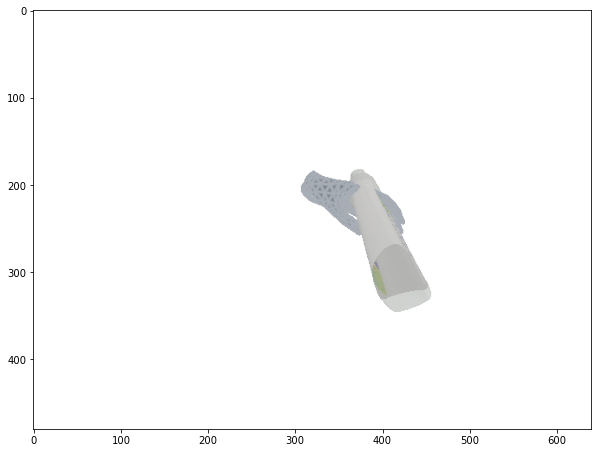

In [24]:
R, T = look_at_view_transform(-1, 0, 0)
cameras = FoVPerspectiveCameras(R=R, T=T)

raster_settings = RasterizationSettings(
    image_size=(480, 640), 
    blur_radius=0.0, 
    faces_per_pixel=1)

lights = PointLights(location=[[0.0, 0.0, 0.0]])

renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras, 
        raster_settings=raster_settings
    ),
    shader=SoftPhongShader(
        cameras=cameras,
        lights=lights
    )
).to('cuda')

images = renderer(all_mesh)
plt.figure(figsize=(10, 10))
plt.imshow(images.cpu().numpy()[0, :, ::-1, :])